In [37]:
from abc import ABC
from pathlib import Path
from timeit import repeat

import matplotlib.pyplot as plt
import pandas as pd

from codetf.models import load_model_pipeline
from transformers import AutoTokenizer, AutoModelWithLMHead, SummarizationPipeline
from scipy import stats

In [38]:
%matplotlib inline

In [ ]:
root_dir = Path.cwd()

In [ ]:
class AbstractModel(ABC):
    def predict(self) -> str:
        raise NotImplementedError()
    
    def model_name(self) -> str:
        raise NotImplementedError()
    
class CodeTFModel(AbstractModel):
    def __init__(self, model_name: str, model_type: str, task: str) -> None:
        super().__init__()

        self._model = load_model_pipeline(model_name=model_name, model_type=model_type, task=task)
        self._model_name = model_name
        self._model_type = model_type
        self._task = task

    def predict(self) -> str:
        return self._model.predict(['def hello(): print("Hello world")'])
    
    def model_name(self) -> str:
        return f"{self._model_name}-{self._model_type}-{self._task}"
    
class SebisModel(AbstractModel):
    def __init__(self, model_name: str) -> None:
        super().__init__()

        self._pipeline = SummarizationPipeline(
            model=AutoModelWithLMHead.from_pretrained(model_name),
            tokenizer=AutoTokenizer.from_pretrained(model_name, skip_special_tokens=True),
            device=0
        )
        self._model_name = model_name

    def predict(self) -> str:
        return self._pipeline(['def hello(): print("Hello world")'])[0]["summary_text"]
    
    def model_name(self) -> str:
        return self._model_name.replace("/", "-")

In [ ]:
def get_runtime(model: AbstractModel):   
    file_path = root_dir / "data" / "runtime" / f"{model.model_name()}.csv"

    if file_path.exists():
        return
    
    #warm up
    model.predict()

    def _predict():
        model.predict()

    with file_path.open("w") as f:
        f.writelines(f"{n}\n" for n in repeat(_predict, number=1, repeat=100))

# Runtime Messung
Im folgenden wird die Laufzeit der Einzelnen Modelle gemessen.

In [ ]:
get_runtime(CodeTFModel(model_name="codet5", model_type="base-multi-sum", task="pretrained"))

In [ ]:
get_runtime(CodeTFModel(model_name="codet5", model_type="base", task="sum_python"))

In [ ]:
get_runtime(SebisModel("SEBIS/code_trans_t5_small_source_code_summarization_python"))

In [ ]:
get_runtime(SebisModel("SEBIS/code_trans_t5_small_source_code_summarization_python_transfer_learning_finetune"))

In [ ]:
get_runtime(SebisModel("SEBIS/code_trans_t5_small_source_code_summarization_python_multitask"))

In [ ]:
get_runtime(SebisModel("SEBIS/code_trans_t5_small_source_code_summarization_python_multitask_finetune"))

In [ ]:
get_runtime(SebisModel("SEBIS/code_trans_t5_base_source_code_summarization_python"))

In [ ]:
get_runtime(SebisModel("SEBIS/code_trans_t5_base_source_code_summarization_python_transfer_learning_finetune"))

In [ ]:
get_runtime(SebisModel("SEBIS/code_trans_t5_base_source_code_summarization_python_multitask"))

In [ ]:
get_runtime(SebisModel("SEBIS/code_trans_t5_base_source_code_summarization_python_multitask_finetune"))

In [ ]:
get_runtime(SebisModel("SEBIS/code_trans_t5_large_source_code_summarization_python_transfer_learning_finetune"))

In [ ]:
get_runtime(SebisModel("SEBIS/code_trans_t5_large_source_code_summarization_python_multitask"))

In [ ]:
get_runtime(SebisModel("SEBIS/code_trans_t5_large_source_code_summarization_python_multitask_finetune"))

# Statistik
## Normalverteilungstest
Zuerst wird überprüft ob die Stichproben Normalverteilt sind für die Wahl der weiteren Tests

In [67]:
def test_norm(values: list) -> None:
    """ Testet eine Stichprobe auf Normalverteilung """
    k2, p = stats.normaltest(values)
    if p < 1e-3: # null hypothesis: values comes from a normal distribution
        return f"The null hypothesis can be rejected (p={p})"
    return f"The null hypothesis cannot be rejected (p={p})"

In [65]:
def get_data():
    return sorted(
        (root_dir / "data" / "runtime").glob("*.csv"),
        key=lambda f: f.name
    )

In [68]:
for csv_file in get_data():
    df = pd.read_csv(csv_file, names=["runtime"])
    print(f"{csv_file.name}:", test_norm(df))   

SEBIS-code_trans_t5_base_source_code_summarization_python.csv: The null hypothesis can be rejected (p=[4.08636685e-07])
SEBIS-code_trans_t5_base_source_code_summarization_python_multitask.csv: The null hypothesis can be rejected (p=[1.84890398e-17])
SEBIS-code_trans_t5_base_source_code_summarization_python_multitask_finetune.csv: The null hypothesis can be rejected (p=[5.10925409e-06])
SEBIS-code_trans_t5_base_source_code_summarization_python_transfer_learning_finetune.csv: The null hypothesis can be rejected (p=[1.09705738e-09])
SEBIS-code_trans_t5_large_source_code_summarization_python_multitask.csv: The null hypothesis can be rejected (p=[2.82526977e-15])
SEBIS-code_trans_t5_large_source_code_summarization_python_multitask_finetune.csv: The null hypothesis can be rejected (p=[1.30820964e-18])
SEBIS-code_trans_t5_large_source_code_summarization_python_transfer_learning_finetune.csv: The null hypothesis cannot be rejected (p=[0.01474419])
SEBIS-code_trans_t5_small_source_code_summariz

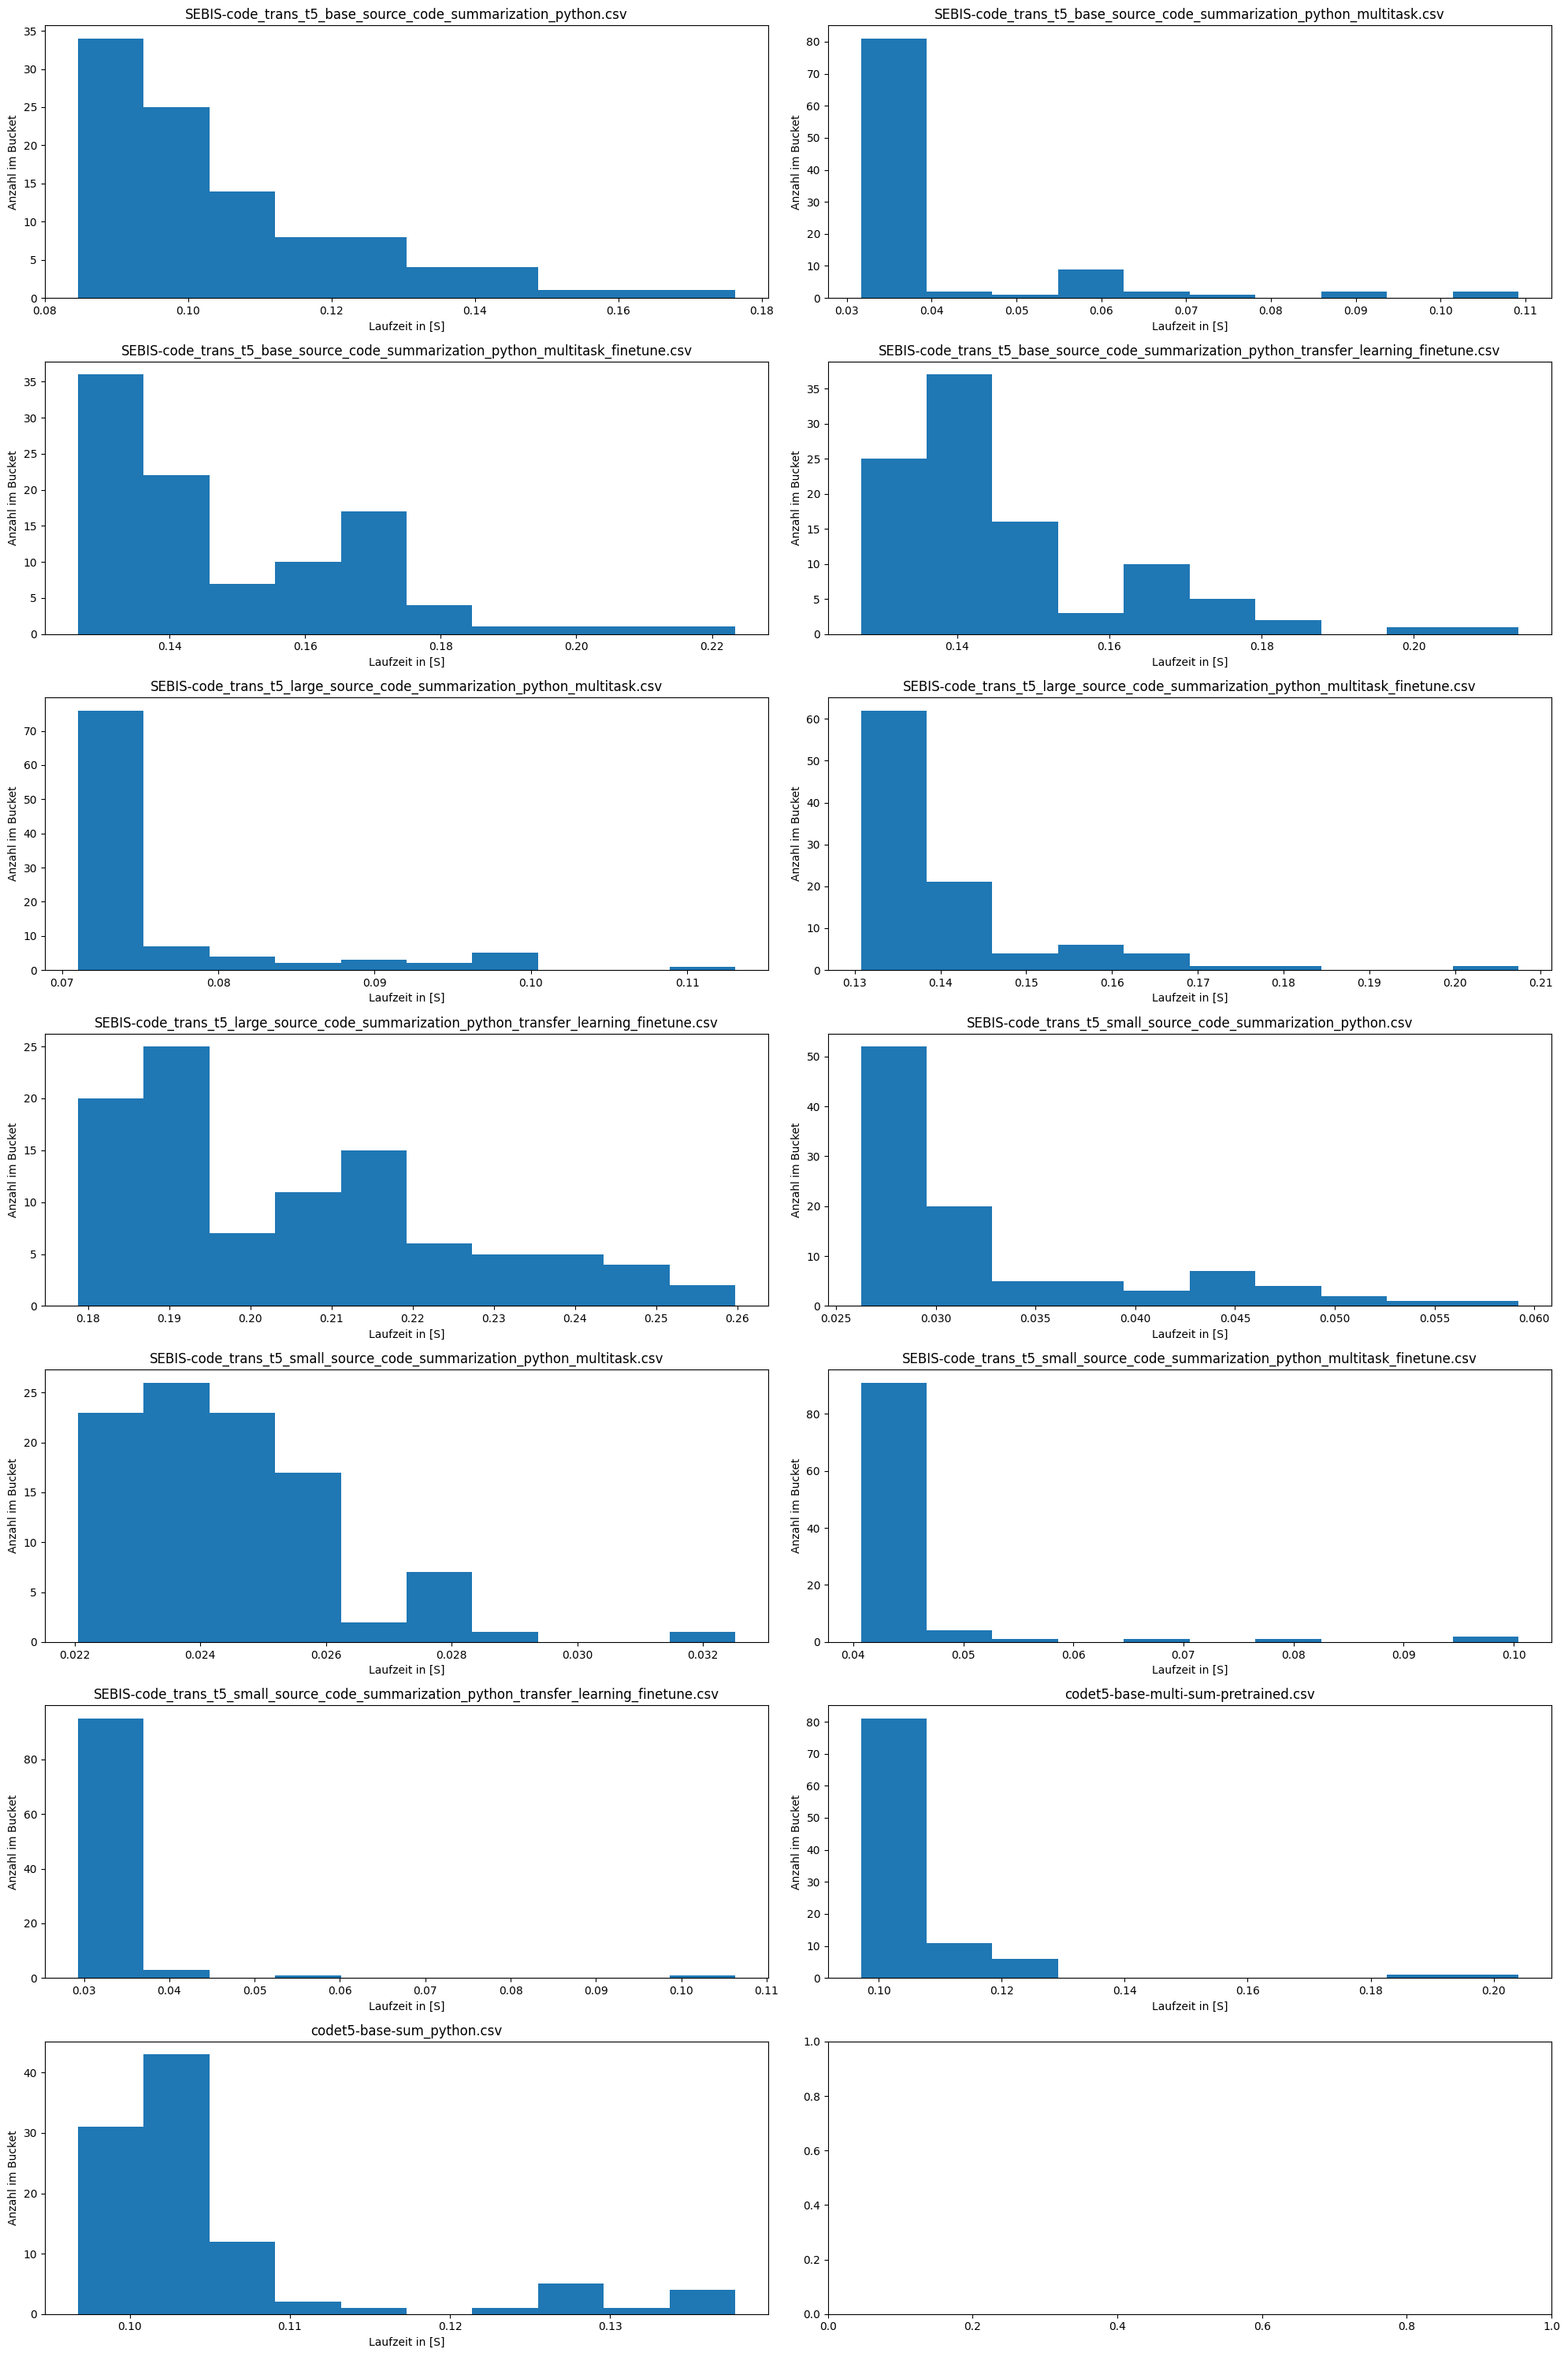

In [58]:
fig, axes = plt.subplots(ncols=2, nrows=7, figsize=(20, 30))

for i, csv_file in enumerate(get_data()):
    df = pd.read_csv(csv_file, names=["runtime"])
    axes[i // 2][i % 2].hist(df)
    axes[i // 2][i % 2].set(
        title=csv_file.name,
        ylabel="Anzahl im Bucket",
        xlabel="Laufzeit in [S]"
    )
plt.tight_layout()

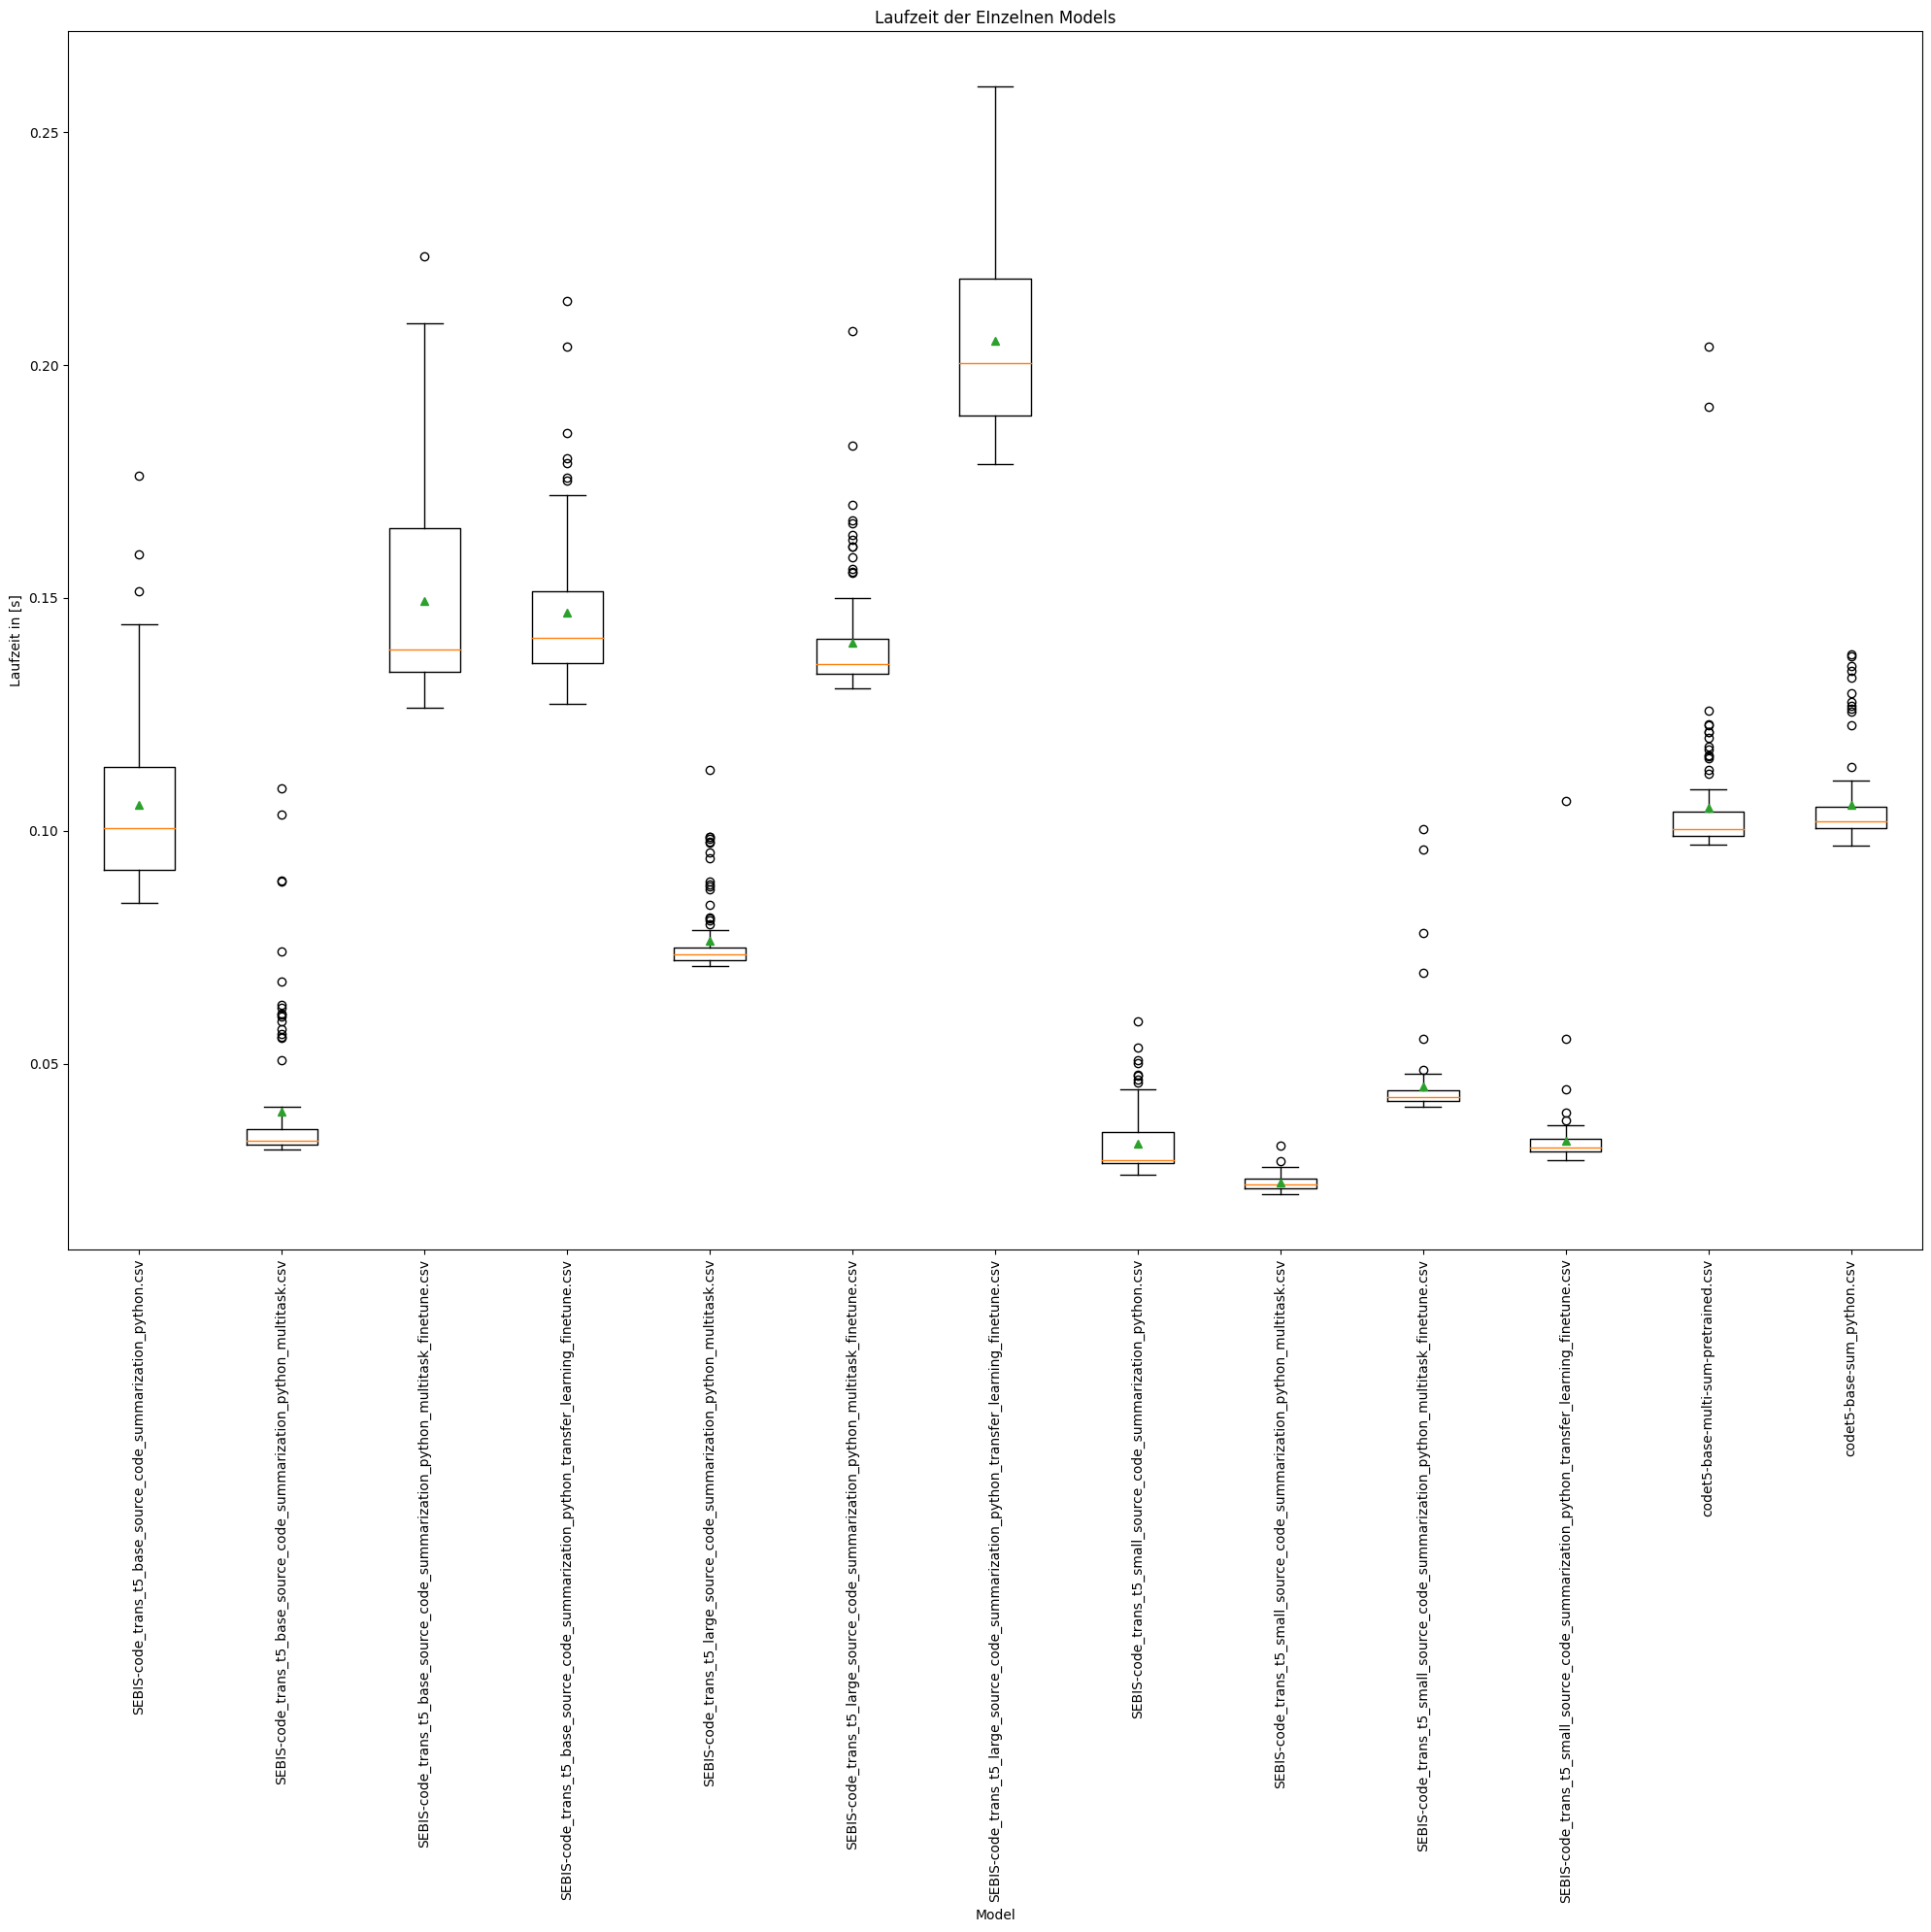

In [59]:
fig, axes = plt.subplots(figsize=(20, 20))

data = {
    csv_file.name: pd.read_csv(csv_file, names=["runtime"])["runtime"]
    for csv_file in get_data()
}

axes.boxplot(data.values(), showmeans=True)
axes.set(
    title="Laufzeit der EInzelnen Models",
    ylabel="Laufzeit in [s]",
    xlabel="Model",
    xticklabels=data.keys(),
)
plt.xticks(rotation=90)
plt.tight_layout()

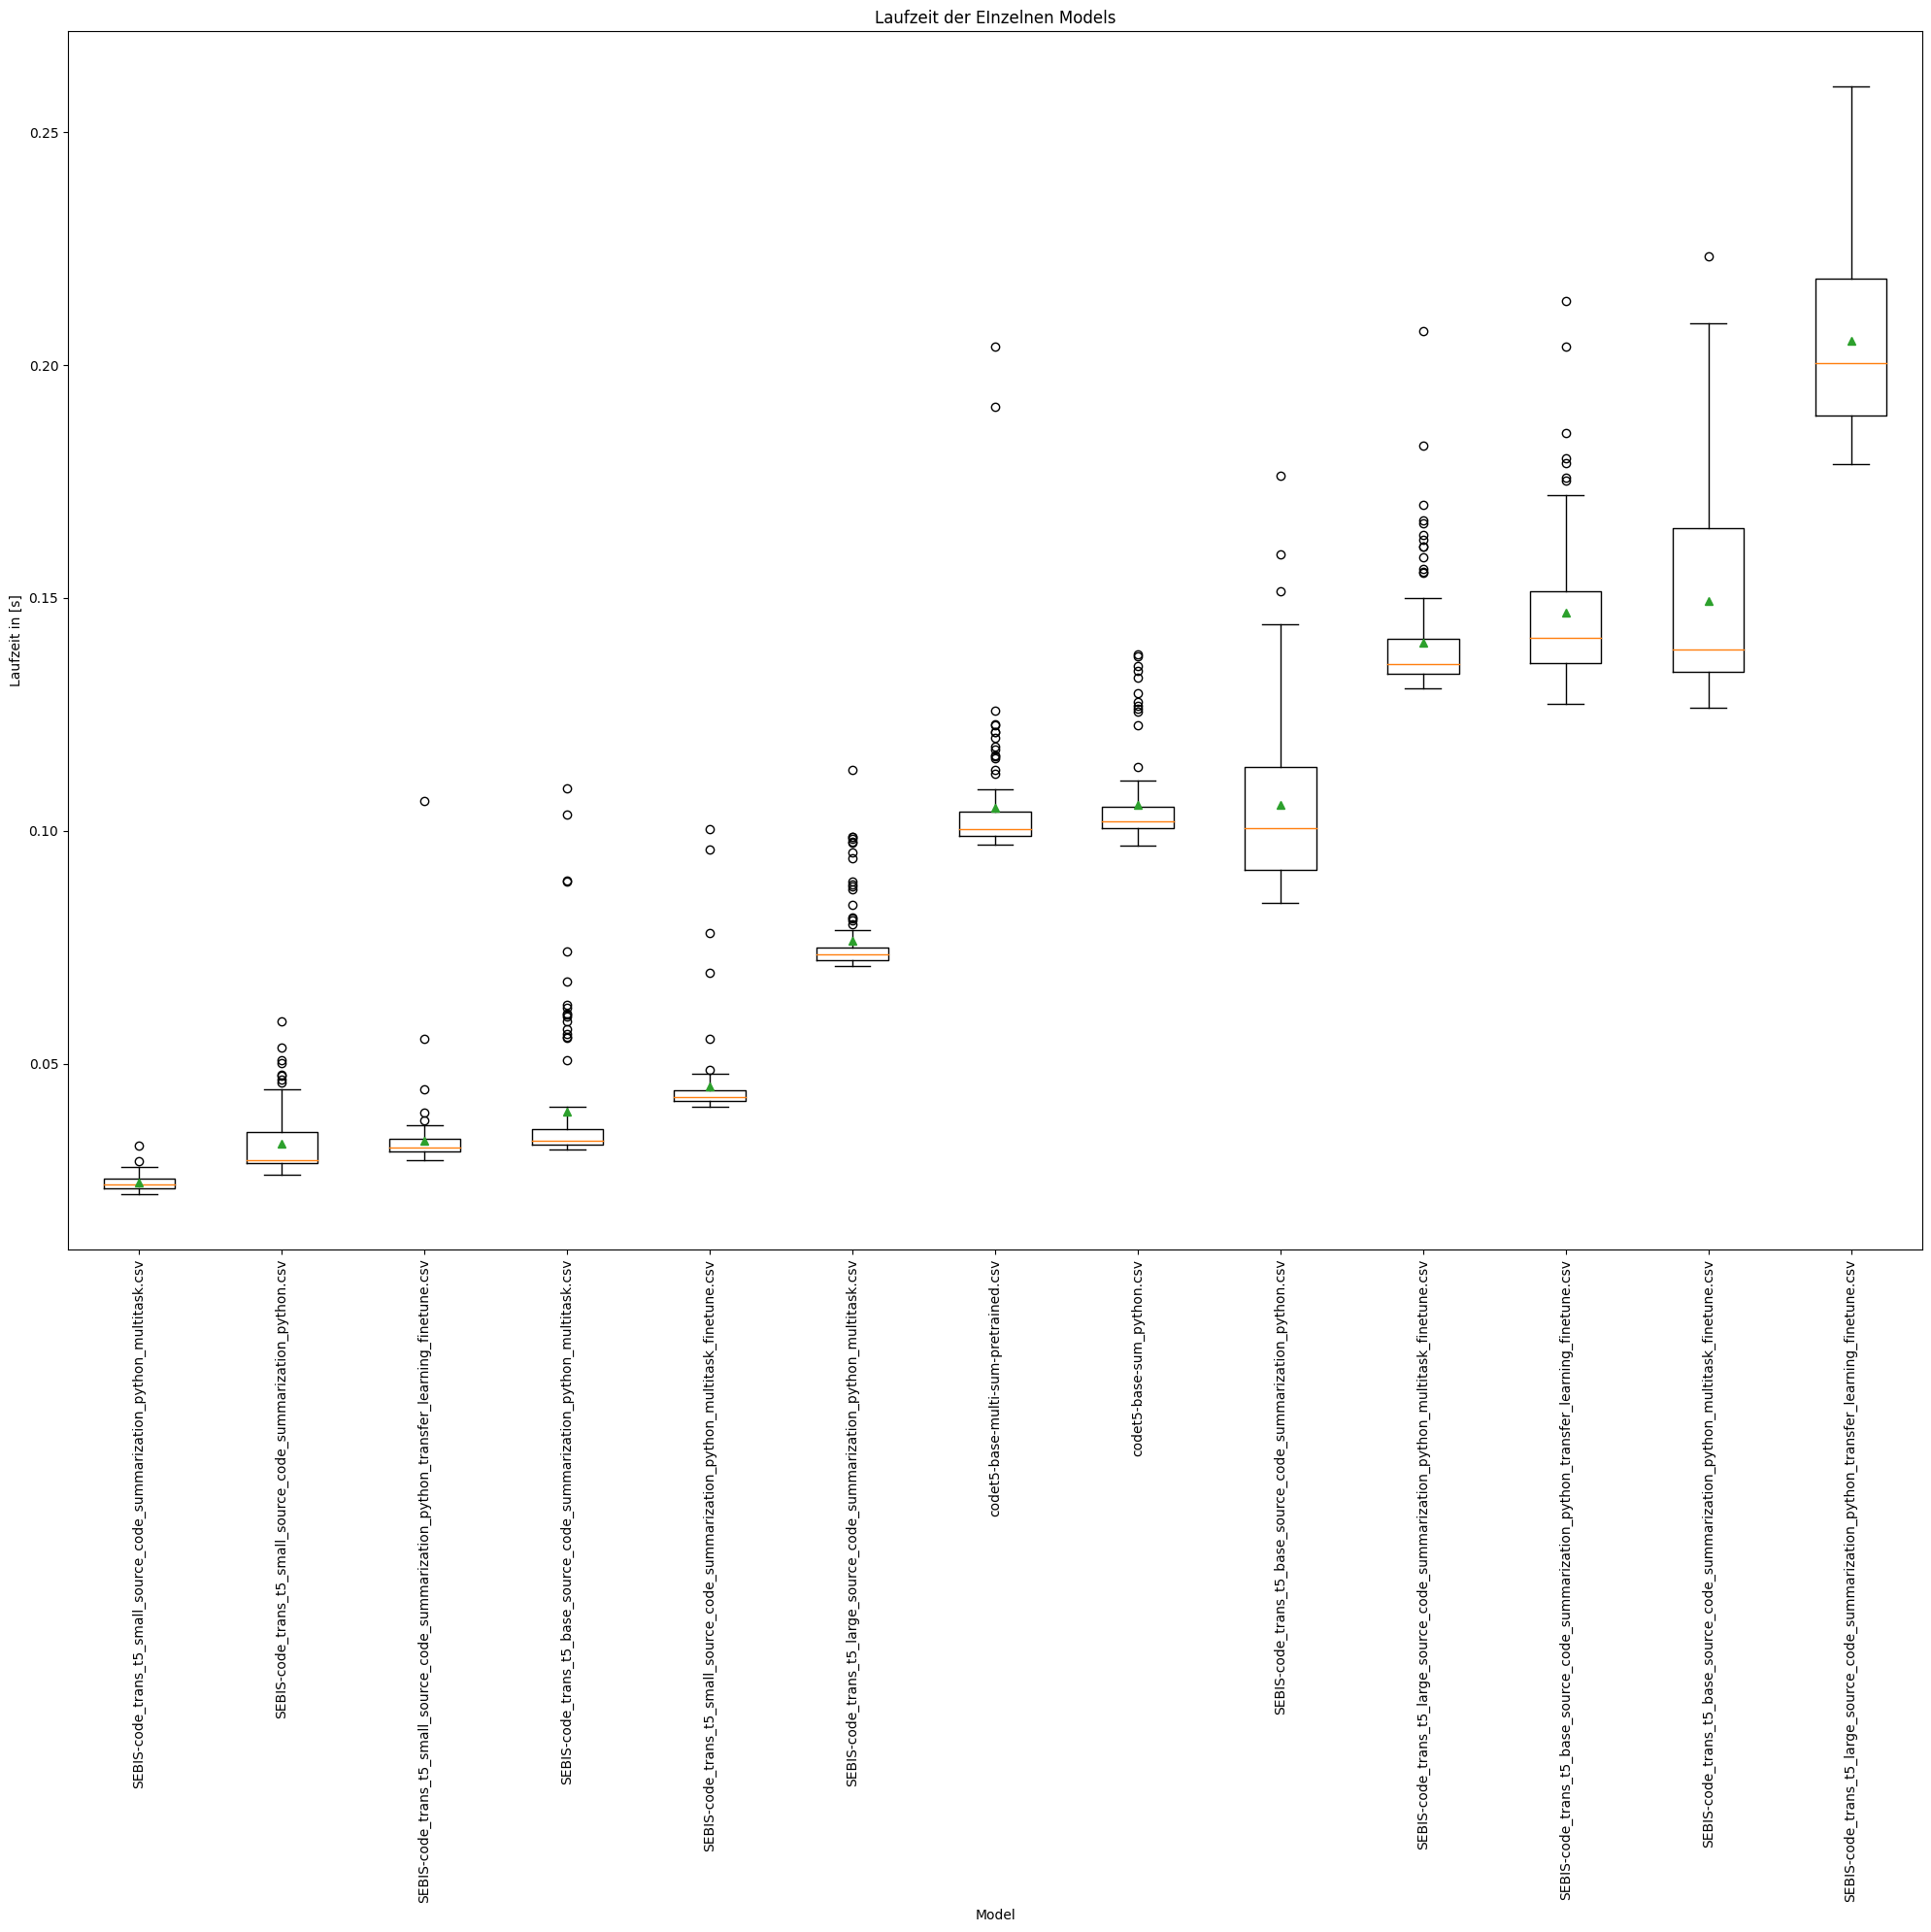

In [61]:
fig, axes = plt.subplots(figsize=(20, 20))

data = dict(sorted({
    csv_file.name: pd.read_csv(csv_file, names=["runtime"])["runtime"]
    for csv_file in get_data()
}.items(),
key=lambda d: d[1].mean()))

axes.boxplot(data.values(), showmeans=True)
axes.set(
    title="Laufzeit der EInzelnen Models",
    ylabel="Laufzeit in [s]",
    xlabel="Model",
    xticklabels=data.keys(),
)
plt.xticks(rotation=90)
plt.tight_layout()

In [ ]:
def test_pair(sample_a: list, sample_b: list) -> None:
    """ Testet ob zwei Stichproben aus der selben Population entstammen """
    u1, p = stats.mannwhitneyu(sample_a, sample_b, method="exact")
    if p < 1e-3: # null hypothesis: values comes from the same group
        return f"The null hypothesis can be rejected (p={p})"
    return f"The null hypothesis cannot be rejected (p={p})"

In [ ]:
for i, (model_a, df_a) in enumerate(data.items[:-1]):
    model_b, df_b = data.items[i + 1]